# Computer Vision - Project 2

### Description

The system recognizes the state of gameplay from a movie (in the selected board game). 

The program tracks the movement of dice and tokens; detects events in the film.

### The input data is divided into 3 groups depending on the difficulty:

- easy: perfect view, the game elements are not covered with your hands when carrying it;

-medium: different dynamics of light in the picture, shadows, light reflections;

- difficult: angled view, game components partially covered with hands when moving, slight shaking of the camera.


# Team members

- Sofya Aksenyuk, 150284

- Uladzimir Ivashka, 150281

# Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import PIL
import os
import sys
import glob
import random

from pprint import pprint
from ipywidgets import Video

from PIL import Image
from PIL.ExifTags import TAGS

# Prerequirements

In [2]:
!pip uninstall --yes gdown
!pip install gdown -U --no-cache-dir

Found existing installation: gdown 4.4.0
Uninstalling gdown-4.4.0:
  Successfully uninstalled gdown-4.4.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
folders_required = ['clipped', 'track', 'templates', 'templates/easy', 'templates/easy/static', 'templates/easy/track']

for folder in folders_required:
  if not os.path.exists(folder):
    os.mkdir(folder)

# Visualization functions

In [4]:
def imshow(a):
  a = a.clip(0, 255).astype('uint8')
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display(PIL.Image.fromarray(a))

In [5]:
def get_coords(bbox):
  p1 = (int(bbox[0]), int(bbox[1]))
  p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
  return p1, p2


def draw_bbox(frame, bbox, color=(255, 0, 0), thickness=2):
  p1, p2 = get_coords(bbox)
  cv2.rectangle(frame, p1, p2, color, thickness, 1)

In [6]:
def get_center(bbox):
    p1, p2 = get_coords(bbox)
    center = (p2[0] - p1[0]) // 2
    return p1[0] + center, p1[1] + center

# Easy dataset

In [7]:
!gdown 1fkLI9OdcRY5YycjbeV8UY_t9iS32MhWT
!unzip dataset-easy-final.zip

Downloading...
From: https://drive.google.com/uc?id=1fkLI9OdcRY5YycjbeV8UY_t9iS32MhWT
To: /content/dataset-easy-final.zip
100% 30.9M/30.9M [00:00<00:00, 172MB/s]
Archive:  dataset-easy-final.zip
  inflating: dataset-easy-final/easy.mp4  


# Creating templates

In [8]:
def read_video(path):
  video = cv2.VideoCapture(path)
  if not video.isOpened():
    assert("Cannot open video")

  video_width = int(video.get(3))
  video_height = int(video.get(4))
  print(f'Video resolution: {video_height}x{video_width}')

  video_fps = video.get(cv2.CAP_PROP_FPS)
  print(f'Video fps: {video_fps}')

  return video, video_width, video_height, video_fps

In [9]:
def create_templates(frame, bboxes_static, bboxes_track, path):

  for name, bbox in bboxes_static.items():
    p1, p2 = get_coords(bbox)
    template = frame[p1[1]:p2[1], p1[0]:p2[0]]
    cv2.imwrite(f'{path}/static/{name}.png', template)
  
  for name, bbox in bboxes_track.items():
    p1, p2 = get_coords(bbox)
    template = frame[p1[1]:p2[1], p1[0]:p2[0]]
    cv2.imwrite(f'{path}/track/{name}.png', template)

Video resolution: 1280x720
Video fps: 30.0

First frame with bboxes:


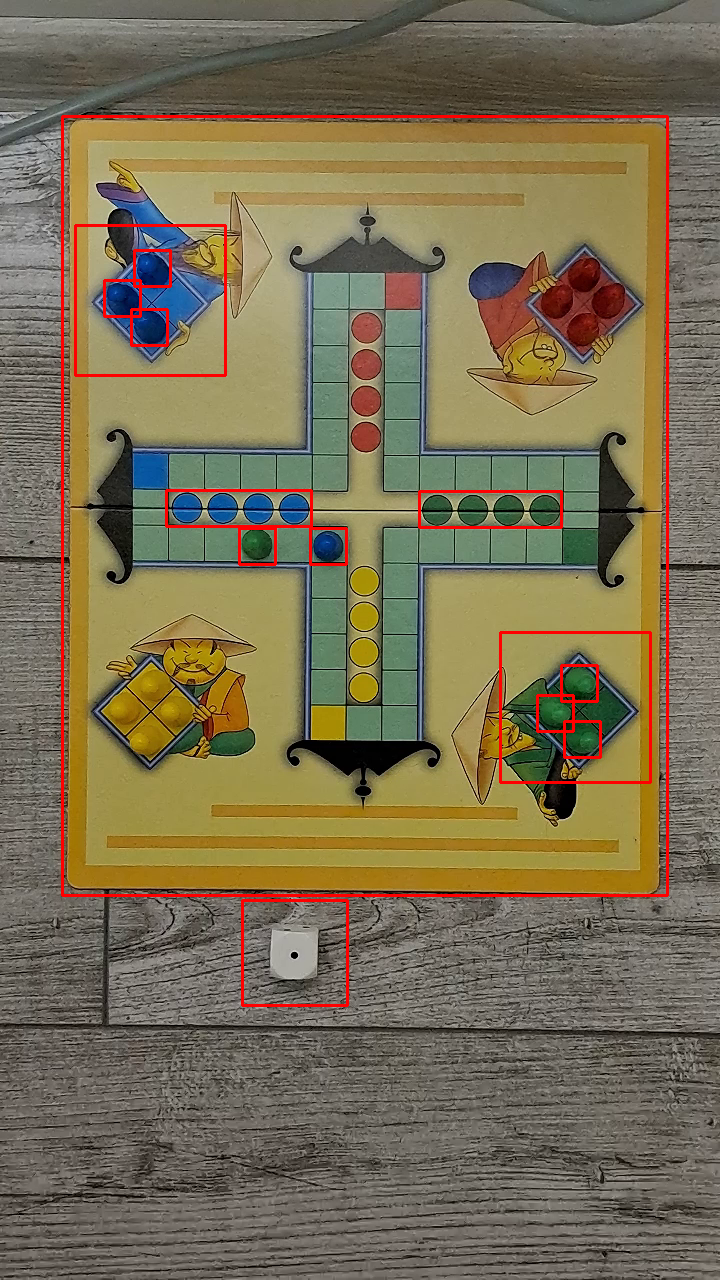

In [14]:
easy = read_video('./dataset-easy-final/easy.mp4')[0]
ret, frame = easy.read()
CELL_SIZE = 36
bboxes_static = dict()
bboxes_track = dict()

## static bboxes
board_bbox = (62, 116, 605, 779)
bboxes_static["board_bbox"] = board_bbox

blue_home_bbox = (166, 490, 145, 36)
bboxes_static["blue_home_bbox"] = blue_home_bbox

green_home_bbox = (419, 491, 142, 36)
bboxes_static["green_home_bbox"] = green_home_bbox

blue_yard_bbox = (75, 225, 150, 150)
bboxes_static["blue_yard_bbox"] = blue_yard_bbox

green_yard_bbox = (500, 632, 150, 150)
bboxes_static["green_yard_bbox"] = green_yard_bbox

## bboxes to track
dice_bbox = (242, 900, 105, 105)
bboxes_track["dice_bbox"] = dice_bbox

blue_bbox1 = (104, 280, CELL_SIZE, CELL_SIZE)
bboxes_track["blue_bbox1"] = blue_bbox1

blue_bbox2 = (134, 250, CELL_SIZE, CELL_SIZE)
bboxes_track["blue_bbox2"] = blue_bbox2

blue_bbox3 = (310, 528, CELL_SIZE, CELL_SIZE)
bboxes_track["blue_bbox3"] = blue_bbox3

blue_bbox4 = (131, 309, CELL_SIZE, CELL_SIZE)
bboxes_track["blue_bbox4"] = blue_bbox4

green_bbox1 = (537, 695, CELL_SIZE, CELL_SIZE)
bboxes_track["green_bbox1"] = green_bbox1

green_bbox2 = (561, 665, CELL_SIZE, CELL_SIZE)
bboxes_track["green_bbox2"] = green_bbox2

green_bbox3 = (239, 528, CELL_SIZE, CELL_SIZE)
bboxes_track["green_bbox3"] = green_bbox3

green_bbox4 = (564, 721, CELL_SIZE, CELL_SIZE)
bboxes_track["green_bbox4"] = green_bbox4


create_templates(frame, bboxes_static, bboxes_track, './templates/easy')

for bbox in bboxes_static.values():
  draw_bbox(frame, bbox, (0, 0, 255), 2)
  
for bbox in bboxes_track.values():
  draw_bbox(frame, bbox, (0, 0, 255), 2)

print(f'\nFirst frame with bboxes:')
imshow(frame)

# Tracking

In [12]:
def create_tracker(tracker_type):
  tracker_types = ['BOOSTING', 'MIL','KCF', 'TLD', 'MEDIANFLOW', 'GOTURN', 'MOSSE', 'CSRT']

  if tracker_type == 'BOOSTING':
      return cv2.legacy.TrackerBoosting_create()
  if tracker_type == 'MIL':
      return cv2.TrackerMIL_create()
  if tracker_type == 'KCF':
      return cv2.TrackerKCF_create()
  if tracker_type == 'TLD':
      return cv2.legacy.TrackerTLD_create()
  if tracker_type == 'MEDIANFLOW':
      return cv2.legacy.TrackerMedianFlow_create()
  if tracker_type == 'GOTURN':
      return cv2.TrackerGOTURN_create()
  if tracker_type == 'MOSSE':
      return cv2.legacy.TrackerMOSSE_create()
  if tracker_type == "CSRT":
      return cv2.legacy.TrackerCSRT_create()

### Read video and find objects from templates

Video resolution: 1280x720
Video fps: 30.0

First frame with detected objects from templates:


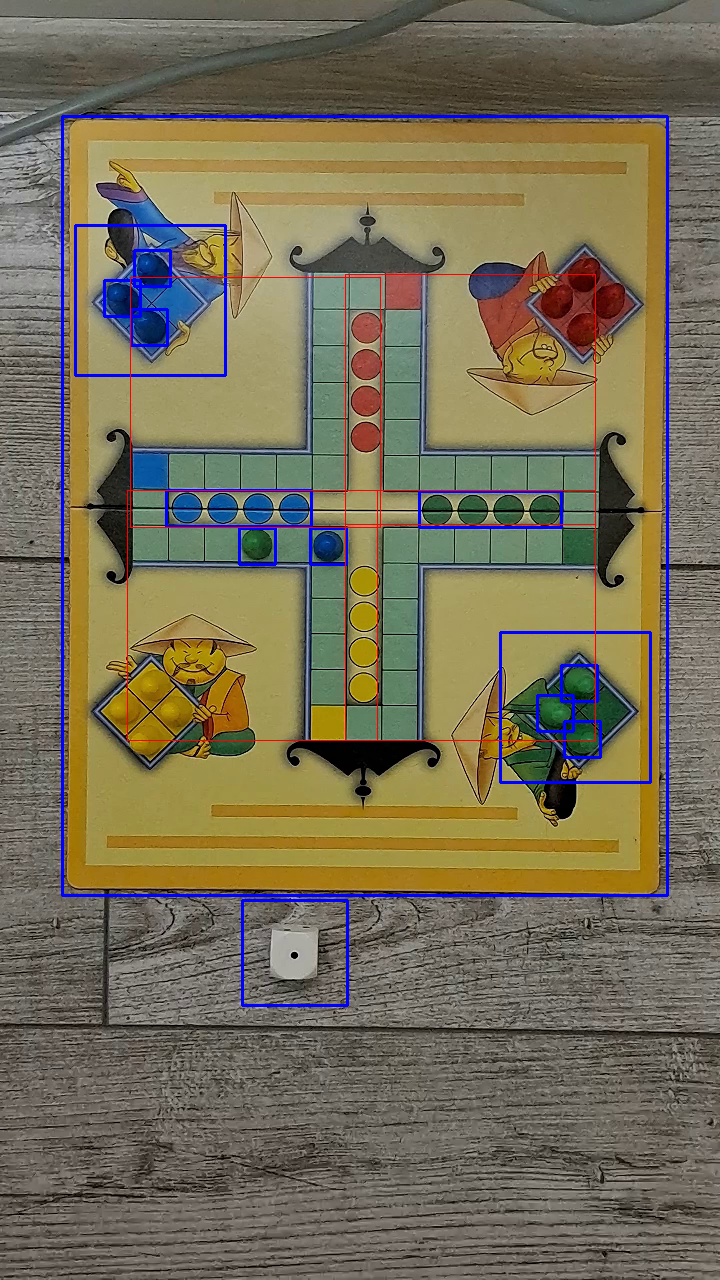

In [40]:
easy, easy_width, easy_height, easy_fps = read_video('./dataset-easy-final/easy.mp4')
ret, frame = easy.read()
bboxes_static = dict()
bboxes_track = dict()

for _file in glob.glob('./templates/easy/static/*'):
  template = cv2.imread(_file, cv2.IMREAD_COLOR)
  _, w, h = template.shape[::-1]
  res = cv2.matchTemplate(frame, template, cv2.TM_CCOEFF_NORMED)
  loc = np.where(res >= 0.9)
  for pt in zip(*loc[::-1]):
    p1, p2 = pt, (pt[0] + w, pt[1] + h)
    bboxes_static[os.path.basename(_file).split('.')[0]] = (p1[0], p1[1], p2[0]-p1[0], p2[1]-p1[1])

for _file in glob.glob('./templates/easy/track/*'):
  template = cv2.imread(_file, cv2.IMREAD_COLOR)
  _, w, h = template.shape[::-1]
  res = cv2.matchTemplate(frame, template, cv2.TM_CCOEFF_NORMED)
  loc = np.where(res >= 0.9)
  for pt in zip(*loc[::-1]):
    p1, p2 = pt, (pt[0] + w, pt[1] + h)
    bboxes_track[os.path.basename(_file).split('.')[0]] = (p1[0], p1[1], p2[0]-p1[0], p2[1]-p1[1])
  
## dividing board to 4 parts
box_parts = {}

left_up_bbox = (130, 277, 250, 250)
box_parts["left_up_bbox"] = left_up_bbox

right_up_bbox = (345, 274, 250, 250)
box_parts["right_up_bbox"] = right_up_bbox

right_down_bbox = (345, 490, 250, 250)
box_parts["right_down_bbox"] = right_down_bbox

left_down_bbox = (127, 490, 250, 250)
box_parts["left_down_bbox"] = left_down_bbox

## compute intersection points
int_points = {}

top = (348, 277, CELL_SIZE, CELL_SIZE)
int_points["up"] = get_center(top)

right = (560, 490, CELL_SIZE, CELL_SIZE)
int_points["right"] = get_center(right)

down = (343, 707, CELL_SIZE, CELL_SIZE)
int_points["down"] = get_center(down)

left = (128, 490, CELL_SIZE, CELL_SIZE)
int_points["left"] = get_center(left)

## showing results
for bbox in bboxes_static.values():
  draw_bbox(frame, bbox, (255, 0, 0), 2)
  
for bbox in bboxes_track.values():
  draw_bbox(frame, bbox, (255, 0, 0), 2)

for bbox in box_parts.values():
  draw_bbox(frame, bbox, (0, 0, 255), 1)

print(f'\nFirst frame with detected objects from templates:')
imshow(frame)

In [41]:
def is_in_bbox(static_bbox, track_bbox):

  center = get_center(track_bbox)
  p1, p2 = get_coords(static_bbox)

  if p1[0] <= center[0] <= p2[0] and p1[1] <= center[1] <= p2[1]:
    return True
    
  return False

In [42]:
def get_stats(frame, boxes, bboxes_static):
  green_home, blue_home = bboxes_static['green_home_bbox'], bboxes_static['blue_home_bbox']
  green_yard, blue_yard = bboxes_static['green_yard_bbox'], bboxes_static['blue_yard_bbox']

  green_score, blue_score = 0, 0
  green_tokens, blue_tokens = 0, 0

  for token in boxes:
    if is_in_bbox(green_home, token):
      green_score += 1
    if is_in_bbox(blue_home, token):
      blue_score += 1

    if is_in_bbox(green_yard, token):
      green_tokens += 1
    if is_in_bbox(blue_yard, token):
      blue_tokens += 1

  return green_score, green_tokens, blue_score, blue_tokens

In [43]:
def get_dice_dots(frame, dice_box):
  p1, p2 = get_coords(dice_box)
  dice = frame[p1[1]:p2[1], p1[0]:p2[0]]

  dice_gray = cv2.cvtColor(dice, cv2.COLOR_BGR2GRAY)
  dice_blur = cv2.GaussianBlur(dice_gray, (3, 3), 0)
  dice_thresh = cv2.threshold(dice_blur, 155, 255, cv2.THRESH_BINARY)[1]

  circles = cv2.HoughCircles(dice_thresh, cv2.HOUGH_GRADIENT, 1, 5, param1=100, param2=8, minRadius=0, maxRadius=5)

  if circles is None:
    return 0
  else:
    return len(circles[0])

In [44]:
def manhattan_distance(point1, point2):
    return sum(abs(value1 - value2) for value1, value2 in zip(point1, point2)) / 36


def token_distance(green_boxes, blue_boxes, bboxes_static, box_parts):
  distances = {}
  green, blue = None, None
  flag = True

  for green_box in green_boxes:
    if (not is_in_bbox(bboxes_static['green_yard_bbox'], green_box)) and (not is_in_bbox(bboxes_static['green_home_bbox'], green_box)):

      for blue_box in blue_boxes:
        if (not is_in_bbox(bboxes_static['blue_yard_bbox'], blue_box)) and (not is_in_bbox(bboxes_static['blue_home_bbox'], blue_box)):

          for name, part in box_parts.items():
            
            if is_in_bbox(part, blue_box) and is_in_bbox(part, green_box):
              distances[tuple(blue_box)] = manhattan_distance(get_center(blue_box), get_center(green_box))
              flag = False

            if is_in_bbox(part, blue_box):
              blue = name
            if is_in_bbox(part, green_box):
              green = name

          if flag and (not green is None) and (not blue is None):
            order = tuple(sorted([green, blue]))
            for inst in dist_instructions[order]:

              if len(inst) == 1:
                distances[tuple(blue_box)] = manhattan_distance(get_center(blue_box), inst[0]) +  manhattan_distance(get_center(green_box), inst[0])

              if len(inst) == 2:
                if order[0] == green:
                  distances[tuple(blue_box)] = manhattan_distance(get_center(green_box), inst[0]) + DIST_CONST + manhattan_distance(get_center(blue_box), inst[1])
                else:
                  distances[tuple(blue_box)] = manhattan_distance(get_center(green_box), inst[1]) + DIST_CONST + manhattan_distance(get_center(blue_box), inst[0])

          green, blue = None, None
          flag = True

  if distances:
    distances = sorted(distances.items(), key=lambda x: x[1])[0]
    return distances[0], distances[1]
  return None, 'no info'

In [45]:
## instructions for computing distance
dist_instructions = {}
dist_instructions[('left_down_bbox', 'left_up_bbox')] = [[int_points['left']]]
dist_instructions[('left_down_bbox', 'right_down_bbox')] = [[int_points['down']]]
dist_instructions[('left_down_bbox', 'right_up_bbox')] = [[int_points['left'], int_points['up']], [int_points['right'], int_points['down']]]
dist_instructions[('left_up_bbox', 'right_down_bbox')] = [[int_points['up'], int_points['right']], [int_points['down'], int_points['left']]]
dist_instructions[('left_up_bbox', 'right_up_bbox')] = [[int_points['up']]]
dist_instructions[('right_down_bbox', 'right_up_bbox')] = [[int_points['right']]]
DIST_CONST = round(manhattan_distance(int_points['left'], int_points['up']) / 36)

### Track objects

In [53]:
easy.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = easy.read()

blue_multiTracker = cv2.legacy.MultiTracker_create()
green_multiTracker = cv2.legacy.MultiTracker_create()
dice_tracker = create_tracker("CSRT")

for name, bbox in bboxes_track.items():
  if name == 'dice_bbox':
    dice_tracker.init(frame, bbox)
  if name.split('_')[0] == 'green':
    green_multiTracker.add(create_tracker("CSRT"), frame, bbox)
  if name.split('_')[0] == 'blue':
    blue_multiTracker.add(create_tracker("CSRT"), frame, bbox)

In [54]:
easy_track = cv2.VideoWriter('./track/easy_track.avi', cv2.VideoWriter_fourcc(*'DIVX'), easy_fps, (easy_width, easy_height))
easy.set(cv2.CAP_PROP_POS_FRAMES, 0)

_green_tokens, _blue_tokens = 9, 9
counter = 0
pos_rip = (99999, 99999)
while easy.isOpened():
  success, frame = easy.read()
  if not success:
    break

  _, green_boxes = green_multiTracker.update(frame)
  _, blue_boxes = blue_multiTracker.update(frame)
  _, dice_box = dice_tracker.update(frame)

  for bbox in bboxes_static.values():
    draw_bbox(frame, bbox, (255, 0, 0), 3)
 
  for newbox in green_boxes:
    draw_bbox(frame, newbox, (0, 0, 255), 2)

  for newbox in blue_boxes:
    draw_bbox(frame, newbox, (0, 0, 255), 2)

  cv2.rectangle(frame, (0, 0), (720, 100), (232, 232, 232), -1)
  green_score, green_tokens, blue_score, blue_tokens = get_stats(frame, np.concatenate([green_boxes,blue_boxes]), bboxes_static)
  frame = cv2.putText(frame, f'Green tokens in yard: {green_tokens}', (10, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
  frame = cv2.putText(frame, f'Blue tokens in yard: {blue_tokens}', (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
  frame = cv2.putText(frame, f'Green score: {green_score}', (470, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
  frame = cv2.putText(frame, f'Blue score: {blue_score}', (470, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

  draw_bbox(frame, dice_box, (0, 255, 0), 3)
  dice_dots = get_dice_dots(frame, dice_box)
  p1, p2 = get_coords(dice_box)
  pos = (p2[0] + 10, (p1[1] + p2[1]) // 2 + 20)
  frame = cv2.putText(frame, f'{dice_dots}', pos, cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3, cv2.LINE_AA)

  if dice_dots == 6:
    frame = cv2.putText(frame, f'Can enter!', (550, 970), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

  pos, dist = token_distance(green_boxes, blue_boxes, bboxes_static, box_parts)
  dist_round = dist
  if isinstance(dist, float) or isinstance(dist, int):
    dist_round = round(dist)
    if dist <= 6:
      frame = cv2.putText(frame, f'Danger!', (450, 1200), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 3, cv2.LINE_AA)
  
  frame = cv2.putText(frame, f'min dist between opponents: {dist_round}', (100, 1250), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

  if counter <= 0 and isinstance(dist, float) and dist < 0.92:
    pos_rip = (int(pos[0]), int(pos[1]) - 20)
    counter = 60
  if counter > 0:
    frame = cv2.putText(frame, f'token rip', pos_rip, cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    counter -= 1

  easy_track.write(frame)

easy_track.release()

In [55]:
!ffmpeg -hide_banner -loglevel error -i ./track/easy_track.avi -y ./track/easy_track.mp4